In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

C:\Users\SOUMIK\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow version: 2.14.0
GPU detected: []


In [2]:
data = pd.read_csv(r"C:\Users\SOUMIK\Desktop\CNER Project\archive\ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
print(num_words, num_tags)

35179 17


In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [9]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
word2idx

{'count': 1,
 'T.': 2,
 '9.5': 3,
 'vomiting': 4,
 'eyesight': 5,
 'pro-immigrant': 6,
 'MINUSTAH': 7,
 '747s': 8,
 'Bormio': 9,
 'Ah': 10,
 'mid-to-late': 11,
 'Malawian': 12,
 'let': 13,
 '220-kilogram': 14,
 'quarterly': 15,
 'Bhairahawa': 16,
 'subsidized': 17,
 'Comoran': 18,
 'attendees': 19,
 'Branko': 20,
 'Dodger': 21,
 'Charm': 22,
 'Abdul-Khalim': 23,
 'airline': 24,
 'humidity': 25,
 'Four-time': 26,
 'utilities': 27,
 'downbeat': 28,
 'Buyat': 29,
 'crisis-related': 30,
 'Pensacola': 31,
 'baked': 32,
 'statue': 33,
 'transformer': 34,
 'defensible': 35,
 'gala': 36,
 'Corazon': 37,
 'floundering': 38,
 'catastrophe': 39,
 'hair-raising': 40,
 'discrepancies': 41,
 'reclaimed': 42,
 'fairly': 43,
 '9.9': 44,
 'Get': 45,
 'redeploy': 46,
 'tabulation': 47,
 'Cashew': 48,
 'tit-for-tat': 49,
 'disburses': 50,
 'Emma': 51,
 'neither': 52,
 'Ganiyev': 53,
 'barrier': 54,
 'Evin': 55,
 'Challenger': 56,
 'nationalizations': 57,
 'Cape': 58,
 'Stosur': 59,
 'visible': 60,
 'sacr

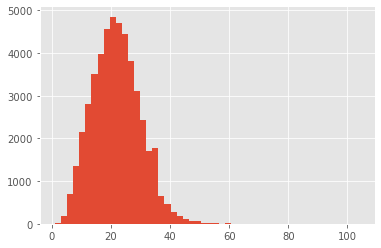

In [10]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [13]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [14]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

In [15]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

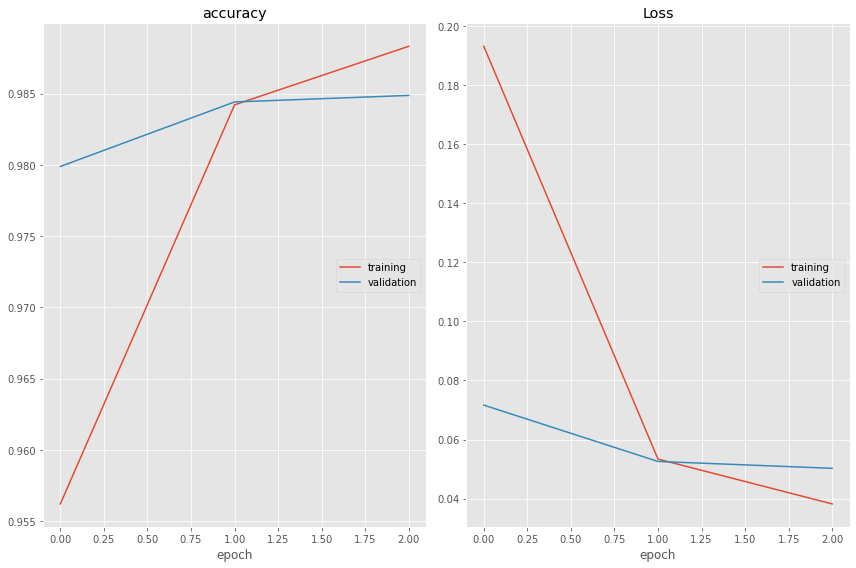

accuracy
	training         	 (min:    0.956, max:    0.988, cur:    0.988)
	validation       	 (min:    0.980, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.038, max:    0.193, cur:    0.038)
	validation       	 (min:    0.050, max:    0.072, cur:    0.050)

Epoch 3: val_loss improved from 0.05260 to 0.05028, saving model to model_weights.h5
1050/1050 [==============================] - 168s 160ms/step - loss: 0.0382 - accuracy: 0.9883 - val_loss: 0.0503 - val_accuracy: 0.9849
Wall time: 8min 31s


In [17]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

In [18]:
model.evaluate(x_test, y_test)

450/450 [==============================] - 14s 30ms/step - loss: 0.0503 - accuracy: 0.9849


[0.05027715116739273, 0.9848665595054626]

In [19]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 928ms/step
Word           True 	 Pred

------------------------------
The            O	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O	O
103            O	O
nuclear        O	O
power          O	O
plants         O	O
in             O	O
31             O	B-tim
states         O	O
.              O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota    O	O
Sriharokota  